Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\vetdd\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\vetdd\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'clf__subsample': 0.6, 'clf__scale_pos_weight': 1.0, 'clf__reg_lambda': 5, 'clf__reg_alpha': 0, 'clf__n_estimators': 800, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}


C:\Users\vetdd\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\vetdd\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✔ Found threshold with Precision≥0.3 & Recall≥0.9
Threshold = 0.254
Precision = 0.400
Recall    = 0.916
Brier score: 0.1012


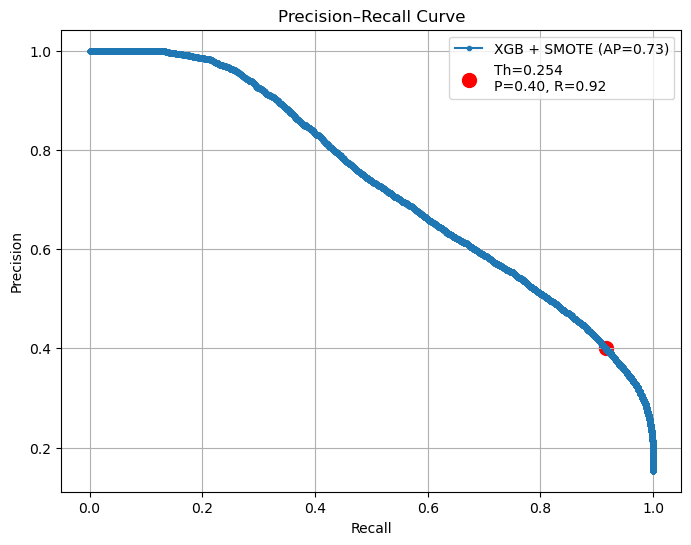

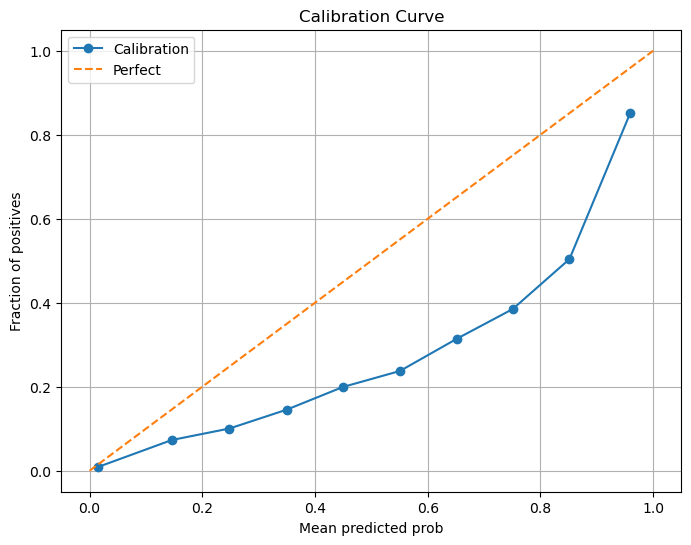

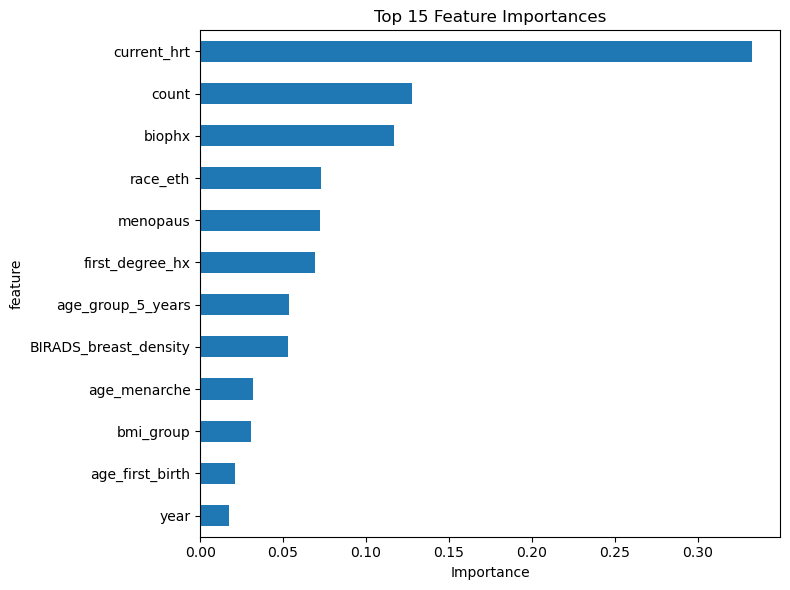

Overall accuracy at threshold 0.254: 0.776
All artifacts saved.


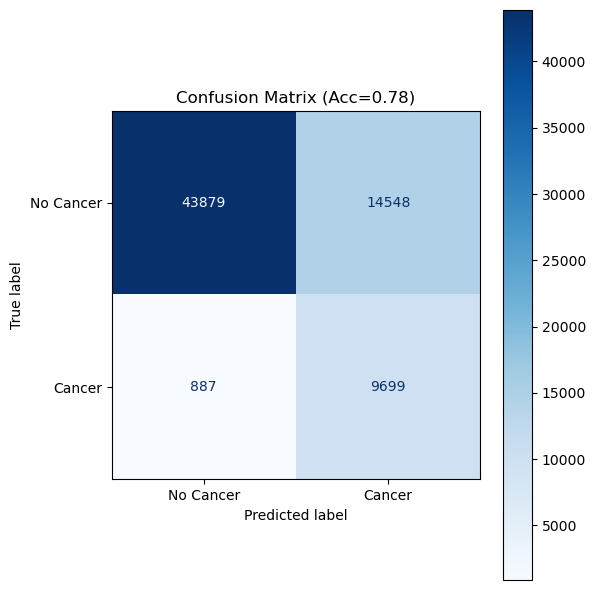

In [1]:
!pip install imbalanced-learn xgboost
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    precision_score, f1_score, make_scorer,
    precision_recall_curve, average_precision_score,
    brier_score_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    matthews_corrcoef
)
from sklearn.calibration import calibration_curve
import xgboost as xgb
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Load & split data
df = pd.read_csv("bcsc_concatenated_no_9.csv")
X = df.drop(columns="breast_cancer_history")
y = df["breast_cancer_history"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# estimate imbalance ratio for prop in grid
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Build an imblearn Pipeline with SMOTE + XGBClassifier 
pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    (
      "clf",
      xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
      )
    )
])

# Hyperparameter grid 
param_dist = {
    "clf__n_estimators":     [100, 300, 500, 800],
    "clf__max_depth":        [3, 5, 7],
    "clf__learning_rate":    [0.01, 0.05, 0.1],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma":            [0, 1, 5],
    "clf__reg_alpha":        [0, 0.1, 1, 5],
    "clf__reg_lambda":       [0.1, 1, 5, 10],
    "clf__scale_pos_weight": [1.0, scale_pos_weight, scale_pos_weight*2, scale_pos_weight*5]
}
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(f1_score, pos_label=1),
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("Best hyperparameters:", search.best_params_)

# Retrain on full training set 
best_pipeline = search.best_estimator_
best_clf = best_pipeline.named_steps["clf"]
best_pipeline.fit(X_train, y_train)

# Predict probabilities on test set & compute PR data 
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

# Threshold selection 

mask = (precision >= 0.4) & (recall >= 0.9)
valid = np.where(mask)[0]

if len(valid) > 0:
    idx = valid[np.argmax(recall[valid])]
    print("✔ Found threshold with Precision≥0.4 & Recall≥0.9")
else:
    # b) fallback: pick threshold that maximizes F1
    f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
    idx = np.argmax(f1_scores)
    print("⚠️  No threshold meets both goals; falling back to best‐F1 point")

matched_precision = precision[idx]
matched_recall    = recall[idx]
matched_threshold = thresholds[idx if idx < len(thresholds) else -1]

print(f"Threshold = {matched_threshold:.3f}")
print(f"Precision = {matched_precision:.3f}")
print(f"Recall    = {matched_recall:.3f}")

# Plot Precision–Recall curve 
fig_pr, ax_pr = plt.subplots(figsize=(8,6))
ax_pr.plot(recall, precision, marker='.', label=f'XGB + SMOTE (AP={avg_prec:.2f})')
ax_pr.scatter(
    matched_recall, matched_precision,
    s=100, color='red',
    label=(f'Th={matched_threshold:.3f}\n'
           f'P={matched_precision:.2f}, R={matched_recall:.2f}')
)
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision–Recall Curve')
ax_pr.grid(True)
ax_pr.legend()

# Calibration & Brier score 
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
brier = brier_score_loss(y_test, y_prob)
print(f"Brier score: {brier:.4f}")

fig_cal, ax_cal = plt.subplots(figsize=(8,6))
ax_cal.plot(prob_pred, prob_true, marker='o', label='Calibration')
ax_cal.plot([0,1], [0,1], linestyle='--', label='Perfect')
ax_cal.set_xlabel('Mean predicted prob')
ax_cal.set_ylabel('Fraction of positives')
ax_cal.set_title('Calibration Curve')
ax_cal.grid(True)
ax_cal.legend()

#9) Feature importances 
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

fig_fi, ax_fi = plt.subplots(figsize=(8,6))
feat_imp.head(15).plot.barh(x='feature', y='importance', legend=False, ax=ax_fi)
ax_fi.invert_yaxis()
ax_fi.set_title('Top 15 Feature Importances')
ax_fi.set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Save files 
os.makedirs("models", exist_ok=True)
joblib.dump(best_clf,      "models/bcsc_xgb_model.pkl")
joblib.dump(matched_threshold, "models/threshold.pkl")
fig_pr.savefig("pr_curve.png", dpi=300)
fig_cal.savefig("calibration_curve.png", dpi=300)
fig_fi.savefig("feature_importance.png", dpi=300)

y_pred_label = (y_prob >= matched_threshold).astype(int)

# Compute accuracy and confusion matrix
acc = accuracy_score(y_test, y_pred_label)
cm  = confusion_matrix(y_test, y_pred_label)
print(f"Overall accuracy at threshold {matched_threshold:.3f}: {acc:.3f}")

# Plot the confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer','Cancer'])
disp.plot(ax=ax_cm, cmap=plt.cm.Blues, values_format='d')
ax_cm.set_title(f'Confusion Matrix (Acc={acc:.2f})')
plt.tight_layout()
fig_cm.savefig("confusion_matrix.png", dpi=300)


print("All files saved.")